In [11]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch_kfac import KFAC
import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load MNIST dataset

In [12]:
batch_size = 1024

In [13]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

In [14]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.convolutions = nn.Sequential(
            nn.Conv2d(1, 2, (7, 7)),
            nn.Tanh(),
            nn.Conv2d(2, 4, (7, 7)),
            nn.Tanh(),
            nn.Conv2d(4, 4, (7, 7)),
            nn.Tanh(),
            nn.Conv2d(4, 8, (7, 7)),
            nn.Tanh(),
        )
        
        self.head = nn.Linear(128, 10)
    
    def forward(self, x):
        out = self.convolutions(x).reshape(x.shape[0], -1)
        return self.head(out)

# KFAC with model distribution

In [30]:
model = Classifier().cuda()
optim = KFAC(model, 9e-3, 1e-3, momentum_type='regular', momentum=0.95, adapt_damping=True, update_cov_manually=True)
loss_fn = nn.CrossEntropyLoss(reduction='mean')

In [31]:
kfac_losses = []
for i in range(10):
    with tqdm.tqdm(train_loader) as progress:
        for inp, labels in progress:
            inp, labels = inp.cuda(), labels.cuda()
            model.zero_grad()
            # Estimate with model distribution
            with optim.track_forward():
                out = model(inp)
                out_samples = torch.multinomial(torch.softmax(out.detach(), 1), 1).reshape(out.shape[0])
                loss = loss_fn(out, out_samples)
            with optim.track_backward():
                loss.backward()
            optim.update_cov()
            # Compute loss to backprop
            model.zero_grad()
            out = model(inp)
            loss = loss_fn(out, labels)
            loss.backward()
            optim.step(loss=loss)
            progress.set_postfix({
                'loss': loss.item(),
                'damping': optim.damping.item()
            })
            kfac_losses.append(loss.item())

100%|█| 59/59 [00:10<00:00,  5.76it/s, loss=0.702, dampin
100%|█| 59/59 [00:10<00:00,  5.87it/s, loss=0.493, dampin
100%|█| 59/59 [00:10<00:00,  5.89it/s, loss=0.382, dampin
100%|█| 59/59 [00:10<00:00,  5.74it/s, loss=0.276, dampin
100%|█| 59/59 [00:10<00:00,  5.73it/s, loss=0.21, damping
100%|█| 59/59 [00:10<00:00,  5.60it/s, loss=0.206, dampin
100%|█| 59/59 [00:10<00:00,  5.80it/s, loss=0.272, dampin
100%|█| 59/59 [00:10<00:00,  5.69it/s, loss=0.231, dampin
100%|█| 59/59 [00:10<00:00,  5.78it/s, loss=0.18, damping
100%|█| 59/59 [00:10<00:00,  5.63it/s, loss=0.18, damping


# KFAC with data distribution

In [33]:
model = Classifier().cuda()
optim = KFAC(model, 9e-3, 1e-3, momentum_type='regular', momentum=0.95, adapt_damping=True, update_cov_manually=False)
loss_fn = nn.CrossEntropyLoss(reduction='mean')

In [34]:
kfac_data_losses = []
for i in range(10):
    with tqdm.tqdm(train_loader) as progress:
        for inp, labels in progress:
            inp, labels = inp.cuda(), labels.cuda()
            model.zero_grad()
            with optim.track_forward():
                out = model(inp)
                loss = loss_fn(out, labels)
            with optim.track_backward():
                loss.backward()
            optim.step(loss=loss)
            progress.set_postfix({
                'loss': loss.item(),
                'damping': optim.damping.item()
            })
            kfac_data_losses.append(loss.item())

100%|█| 59/59 [00:09<00:00,  6.11it/s, loss=0.695, dampin
100%|█| 59/59 [00:09<00:00,  6.01it/s, loss=0.341, dampin
100%|█| 59/59 [00:09<00:00,  6.20it/s, loss=0.291, dampin
100%|█| 59/59 [00:09<00:00,  6.13it/s, loss=0.239, dampin
100%|█| 59/59 [00:09<00:00,  6.19it/s, loss=0.202, dampin
100%|█| 59/59 [00:09<00:00,  6.07it/s, loss=0.264, dampin
100%|█| 59/59 [00:09<00:00,  6.06it/s, loss=0.21, damping
100%|█| 59/59 [00:10<00:00,  5.85it/s, loss=0.173, dampin
100%|█| 59/59 [00:09<00:00,  6.04it/s, loss=0.112, dampin
100%|█| 59/59 [00:09<00:00,  5.94it/s, loss=0.171, dampin


# Adam

In [35]:
model = Classifier().cuda()
optim = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss(reduction='mean')

In [36]:
adam_losses = []
for i in range(10):
    with tqdm.tqdm(train_loader) as progress:
        for inp, labels in progress:
            inp, labels = inp.cuda(), labels.cuda()
            model.zero_grad()
            out = model(inp)
            loss = loss_fn(out, labels)
            loss.backward()
            optim.step()
            progress.set_postfix({
                'loss': loss.item()
            })
            adam_losses.append(loss.item())

100%|████████| 59/59 [00:08<00:00,  6.94it/s, loss=0.171]


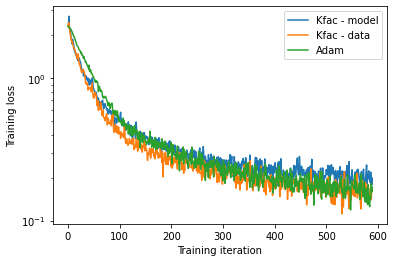

In [37]:
import matplotlib.pyplot as plt
plt.plot(kfac_losses)
plt.plot(kfac_data_losses)
plt.plot(adam_losses)
plt.xlabel('Training iteration')
plt.ylabel('Training loss')
plt.yscale('log')
plt.legend(['Kfac - model', 'Kfac - data', 'Adam'])